In [3]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt

print(sys.path)
# to import stanify library
home_path = "/Users/hyunjimoon/Dropbox/tolzul/BayesSD/code/pipeline/prescriptive/stanify"
sys.path.append(home_path)
from stanify.builders.vensim2stan import Vensim2Stan
from stanify.calibrator.plots import plot_ecdf, plot_rank_hist
# read vensim model stored in vensim_models folder
vensim_model_path = home_path + "/vensim_models/inventory/inventory.mdl"

['/Users/hyunjimoon/Dropbox/tolzul/BayesSD/code/pipeline/prescriptive/stanify/vignette', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/hyunjimoon/Dropbox/tolzul/BayesSD/code/pipeline/prescriptive/venv/lib/python3.10/site-packages']


Previously in [sbc library's vignette](https://hyunjimoon.github.io/SBC/articles/index.html), users had to manually implement generators either in R or Stan's generated quatities. Maintaining consistency between generator and estimator of one model on top of between [network of different models in model families](http://ryanbe.me/) wasn't easy. This is the painpoint stanify addresses. It auto-translates ode equations (.mdl file format of [Vensim](https://vensim.com/). Vensim is a widely software for:
- generating agent-based and compartment dynamic simulation models
- estimating parameters with optimization, MCMC, filtering methods
- testing causal loops and parameter sensitivity
- publishing [online simulator](https://vensim.com/temp/cwd1/#)
- [diverse application](https://www.ventanasystems.com/examples_general/) in infrastructure, energy, marketing and operations with more than 10k users

In [5]:
v2s_code = """
ss_obs[timesteps] ~ normal(ss[timesteps], sigma);
s_obs[timesteps] ~ normal(s[timesteps], sigma_s);
sigma<lower=0.1> ~ lognormal(0, 1);
sigma_s<lower=0.1> ~ lognormal(0, 1);
"""

Driving data is supplied through python as `additional_data` parameter. Vensim uses its own `.vdfx` format for speed up, but this is a design choice to bring vensim to more open platform.

In [7]:
max_time = 100
timesteps = np.arange(0, max_time, dtype=np.float32) + 1e-6

v2s = Vensim2Stan(v2s_code, vensim_model_path, ["ss_obs", "s_obs"], initial_time=0, integration_times=timesteps, 
                  additional_data={"exog demand": xr.DataArray(2 * timesteps + 100, dims=["timesteps"], coords={"timesteps": timesteps.astype(np.int64)})})

Constructing sbc inferencedata for systematic testing.

In [8]:
sbc_idata = v2s.run_sbc(n_fits=100, n_draws=500, n_chains=4, iter_warmup=500)

Running SBC for dataset # 100 of 100


13:10:46 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:11:26 - cmdstanpy - INFO - CmdStan done processing.


In [ ]:
sbc_idata.prior.dims

Frozen({'prior_draw': 10, 'initial_state_dim_0': 4, 'ode_result_dim_0': 100, 'ode_result_dim_1': 4, 'timesteps': 100})

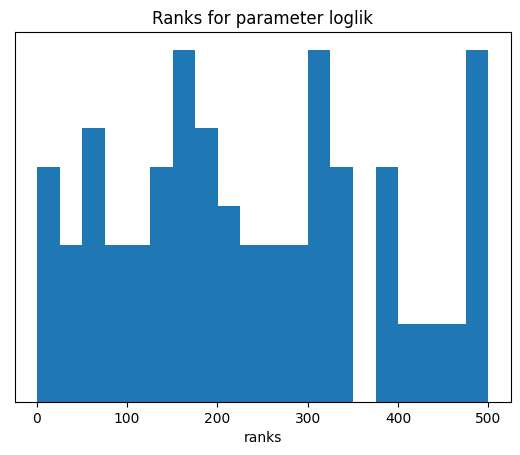

In [9]:
plot_rank_hist(sbc_idata, "loglik")

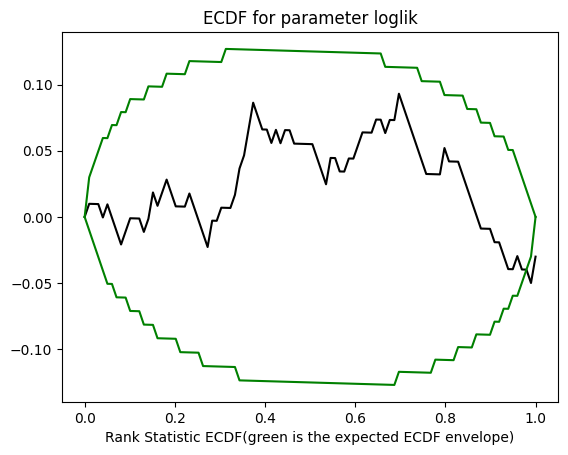

In [10]:
plot_ecdf(sbc_idata, "loglik", diff=True)

In [14]:
sbc_idata

Inference data with groups:
	> posterior
	> prior
	> prior_predictive
	> sample_stats_prior

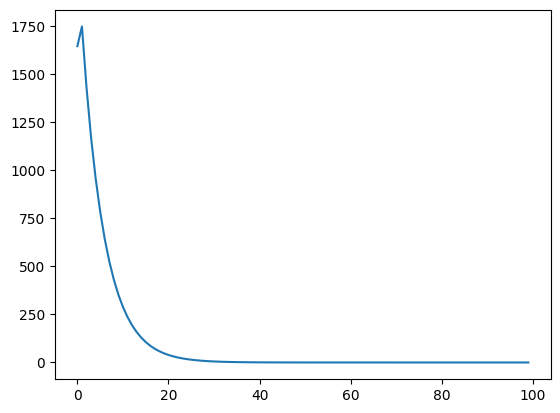

In [15]:
plt.plot(sbc_idata.posterior["ss"].sel(prior_draw=0).mean(dim="posterior_draw"))

(array([  3.,  26.,  65., 128., 120., 101.,  42.,  12.,   2.,   1.]),
 array([0.115735 , 0.1237091, 0.1316832, 0.1396573, 0.1476314, 0.1556055,
        0.1635796, 0.1715537, 0.1795278, 0.1875019, 0.195476 ]),
 <BarContainer object of 10 artists>)

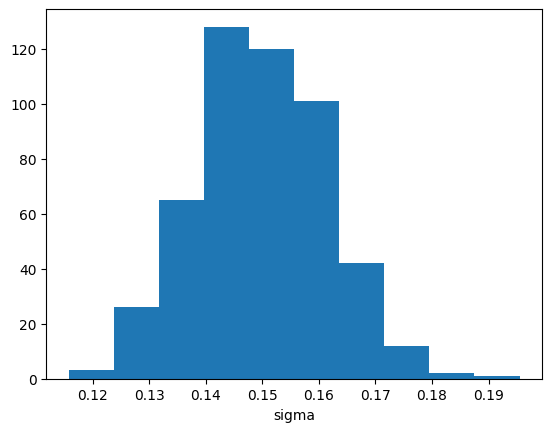

In [19]:
sbc_idata.posterior["sigma"].sel(prior_draw=0).plot.hist()
#sbc_idata.posterior["adj_s"].sel(prior_draw=0)

(array([ 11.,  27.,  51., 127., 106.,  74.,  60.,  29.,  13.,   2.]),
 array([0.293883 , 0.3074695, 0.321056 , 0.3346425, 0.348229 , 0.3618155,
        0.375402 , 0.3889885, 0.402575 , 0.4161615, 0.429748 ]),
 <BarContainer object of 10 artists>)

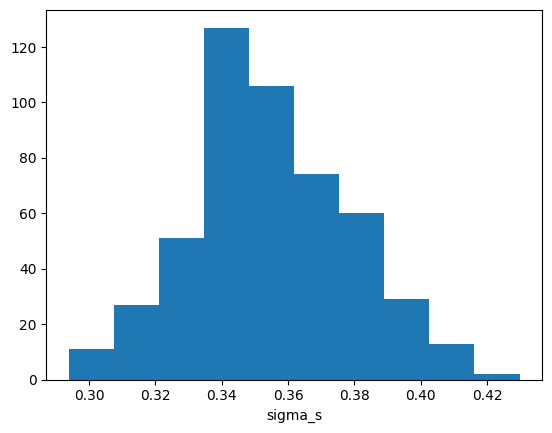

In [20]:
sbc_idata.posterior["sigma_s"].sel(prior_draw=0).plot.hist()